# Using the Keras API

The first step in creating a neural network model is to define the **Input layer**. This layer takes in raw data, usually in the form of numpy arrays. The shape of the Input layer defines how many variables your neural network will use. For example, if the input data has 10 columns, you define an Input layer with a shape of (10,).

In this case, you are only using one input in your network.

In [1]:
import pandas as pd
import numpy as np
from numpy import unique
import matplotlib.pyplot as plt

In [2]:
from keras.layers import Input, Dense, Embedding, Flatten, Subtract
from keras.models import Model
from keras.utils import plot_model

# Create an input layer of shape 1
input_tensor = Input(shape=(1,))

Using TensorFlow backend.


Once you have an Input layer, the next step is to add a **Dense layer**.

Dense layers learn a weight matrix, where the first dimension of the matrix is the dimension of the input data, and the second dimension is the dimension of the output data. Recall that our Input layer has a shape of 1. In this case, our output layer will also have a shape of 1. This means that the Dense layer will learn a 1x1 weight matrix.

In [3]:
# Dense layer
output_layer = Dense(1)

# Connect the dense layer to the input_tensor, pass 'input_tensor' to 'output_layer()''.
output_tensor = output_layer(input_tensor)

Output layers are simply Dense layers! **Output layers are used to reduce the dimension of the inputs to the dimension of the outputs**. For now, we'll always use a single output in our neural networks, which is equivalent to `Dense(1)` or a dense layer with a single unit or node.

In [4]:
# We can create a dense layer and connect the dense layer to the 'input_tensor' in one step.
# Note that we did this in 2 steps in the previous step
output_tensor = Dense(1)(input_tensor)

Once we've defined an input layer and an output layer, you can build a Keras model. The model object is how you tell Keras where the model starts and stops: where data comes in and where predictions come out.

In [5]:
model = Model(input_tensor, output_tensor)

Our `model` object is a complete neural network, ready to learn from data and make prediction.

The final step in creating a model is compiling it. Now that you've created a model, we have to compile it before you can fit it to data. This finalizes our model, freezes all its settings, and prepares it to meet some data!

During compilation, you specify the optimizer to use for fitting the model to the data, and a loss function. `adam` is a good default optimizer to use, and will generally work well. Loss function depends on the problem at hand. Mean squared error is a common loss function and will optimize for predicting the mean, as is done in least squares regression.

Mean absolute error optimizes for the median and is used in quantile regression (since it uses median it's less influenced by outliers). For this dataset, 'mean_absolute_error' works pretty well, so use it as your loss function.

In [6]:
model.compile(optimizer='adam', loss='mean_absolute_error')

Once the model has been compiled, plot a model summary with `model.summary()`.

The summary will tell you the names of the layers, as well as how many units they have and how many parameters are in the model.

We can also plot the model, this will show how the layers connect to each other. The `plot_model` function will generate an image of the model architecture which can be viewed using the matplotlib library.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


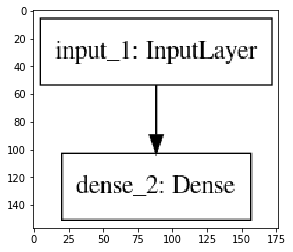

In [7]:
# Summarize the model
model.summary()

# Plot the model
plot_model(model, to_file='./img/model.png')

# Display the image
data = plt.imread('./img/model.png')
plt.imshow(data)
plt.show()

### Fit the Model

The dataset are the scores from US College Basketball tournament games. Each row of the dataset has the team ids: `team_1` and `team_2`, as integers. It also has the seed difference between the teams (seeds are assigned by the tournament committee and represent a ranking of how strong the teams are) and the score difference of the game (e.g. if team_1 wins by 5 points, the score difference is 5).

To fit the model, provide a matrix of X variables (in this case one column: the seed difference) and a matrix of Y variables (in this case one column: the score difference).

In [8]:
# load the tornament data
games = pd.read_csv('./data/basket-ball/games_tourney.csv')
print(games.shape)
games.head()

(4234, 9)


,season,team_1,team_2,home,seed_diff,score_diff,score_1,score_2,won
0,1985,288,73,0,-3,-9,41,50,0
1,1985,5929,73,0,4,6,61,55,1
2,1985,9884,73,0,5,-4,59,63,0
3,1985,73,288,0,3,9,50,41,1
4,1985,3920,410,0,1,-9,54,63,0


In [9]:
# we'll split the data into train and split so as to evaluate the model on un-seen data
# we'll set aside ~20%, 846 rows
train, test = games[:3388].copy(), games[3388:].copy()
train.shape, test.shape

((3388, 9), (846, 9))

In [10]:
# fit the model
model.fit(
    train['seed_diff'],  # X - predictors
    train['score_diff'], # y - target
    epochs=1,
    batch_size=128, # number of rows processed at a time
    validation_split=0.2,
    verbose=True
)

Train on 2710 samples, validate on 678 samples
Epoch 1/1
2710/2710 [==============================] - 0s 86us/step - loss: 9.8243 - val_loss: 10.0300


### Evaluate the Model

After fitting the model, we can evaluate it on new data. We will give the model a new `X` matrix (also called test data), allow it to make predictions, and then compare to the known `y` variable (also called target data).

In [11]:
# Load the X and y variable from the test data
X_test, y_test = test['seed_diff'], test['score_diff']

# Evaluate the model on the test data
model.evaluate(X_test, y_test)

846/846 [==============================] - 0s 41us/step


9.560960431470939

### Using an Embedding Layer

Using an embedding layer allows neural nets to handle highly cardinal categories.

Shared layers allow a model to use the same weight matrix for multiple steps. We'll build a "team strength" layer that represents each team by a single number. We'll use this number for both teams in the model. The model will learn a number for each team that works well both when the team is `team_1` and when the team is `team_2` in the input data.

In [21]:
# load the full dataset of 10888 teams
full = pd.read_csv('./data/basket-ball/games_season.csv')
print(full.shape)
full.head()

(312178, 8)


,season,team_1,team_2,home,score_diff,score_1,score_2,won
0,1985,3745,6664,0,17,81,64,1
1,1985,126,7493,1,7,77,70,1
2,1985,288,3593,1,7,63,56,1
3,1985,1846,9881,1,16,70,54,1
4,1985,2675,10298,1,12,86,74,1


In [23]:
# Count the unique number of teams
# n_teams = 10888 # hack to make the model work
n_teams = unique(full['team_1']).shape[0]
print(n_teams)


# Create an embedding layer
team_lookup = Embedding(
    input_dim=n_teams,
    output_dim=1,
    input_length=1,
    name='Team-Strength'
)

10888


### Define the Team Model

![Embedding Layer](./img/embedding-layer.png)

The team strength lookup has three components: an input, an embedding layer, and a flatten layer that creates the output.

If you wrap these three layers in a model with an input and output, you can re-use that stack of three layers at multiple places.

Note again that the weights for all three layers will be shared everywhere we use them.

In [24]:
# Create a 1D input layer for the team ID (which will be an integer). 
# Be sure to set the correct input shape!
teamid_in = Input(shape=(1,)) # input tensor

# Lookup the input in the team strength embedding layer
# Pass this input to the team strength lookup layer created previously.
strength_lookup = team_lookup(teamid_in)

# Flatten the output
strength_lookup_flat = Flatten()(strength_lookup) # output tensor

# Combine the operations into a single, re-usable model
# combine the input and output layers and provide the model a name (for debugging)
team_strength_model = Model(teamid_in, strength_lookup_flat, name='Team-Strength-Model')

The resulting model will be reusable, so we can use it in two places in our final model.

### Shared Layers

We'ill define two input layers for the two teams in our model. Later in the model we'll be able to define how the data from each team will be used differently. These two inputs will be used later for the shared layer.

In [25]:
# Input layer for team 1
team_in_1 = Input(shape=(1,), name='Team-1-In')

# Separate input layer for team 2
team_in_2 = Input(shape=(1,), name='Team-2-In')

Now that we have a team strength model and an input layer for each team, we can lookup the team inputs in the shared team strength model. The two inputs will share the same weights.

In this dataset, we have 10,888 unique teams. We want to learn a strength rating for each team, such that if any pair of teams plays each other, we can predict the score, even if those two teams have never played before. Furthermore, we want the strength rating to be the same, regardless of whether the team is the home team or the away team.

To achieve this, we use a shared layer, defined by the re-usable model (team_strength_model()) we built earlier and the two input layers (`team_in_1` and `team_in_2`) from previously.

In [26]:
# Lookup team 1 in the team strength model
team_1_strength = team_strength_model(team_in_1)

# Lookup team 2 in the team strength model
team_2_strength = team_strength_model(team_in_2)

Now our model knows how strong each team is.

Now that we've looked up how "strong" each team is, we subtract the team strengths to determine which team is expected to win the game.

This is a bit like the seeds that the tournament committee uses, which are also a measure of team strength. But rather than using seed differences to predict score differences, we'll use the difference of our own team strength model to predict score differences.

The subtract layer will combine the weights from the two layers by subtracting them.

In [27]:
# Create a subtract layer or the previous two team strength layers
score_diff = Subtract()([team_1_strength, team_2_strength])

This setup subracts the team strength ratings to determine a winner.

Now that you have your two inputs (team id 1 and team id 2) and output (score difference), we can wrap them up in a model so we can use it later for fitting to data and evaluating on new data.

Oour model will look like the following diagram:

![Model](./img/basketball-model.png)

In [28]:
# Define a model with the two teams as inputs and use the score difference as the output.
model = Model([team_in_1, team_in_2], score_diff)

# Compile the model with the 'adam' optimizer and 'mean_absolute_error' loss.
model.compile(optimizer='adam', loss='mean_absolute_error')

The model is now finalized and ready to fit to data. Since since it has two inputs, we need to pass the input data as a list.

In [29]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Team-1-In (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
Team-2-In (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
Team-Strength-Model (Model)     (None, 1)            10888       Team-1-In[0][0]                  
                                                                 Team-2-In[0][0]                  
__________________________________________________________________________________________________
subtract_2 (Subtract)           (None, 1)            0           Team-Strength-Model[1][0]        
          

In [30]:
# Assign the 'team_1' and 'team_2' columns from dataset to input_1 and input_2, respectively.
input_1, input_2 = full['team_1'], full['team_2']

# Fit the model to input 1 and 2, using score diff as a target
model.fit(
    [input_1, input_2], # predictors, multiple inputs
    full['score_diff'], # target
    epochs=1,
    batch_size=2048,
    validation_split=0.1,
    verbose=True
)

Train on 280960 samples, validate on 31218 samples
Epoch 1/1
280960/280960 [==============================] - 1s 3us/step - loss: 12.1202 - val_loss: 11.8376


We'll evaluate the model on the `games`, tournament dataset. This evaluation will tell us how well we can predict the tournament games, based on a model trained with the `full` dataset. This is interesting because many teams play each other in the tournament that did not play in the regular season, so this is a very good check that our model is not overfitting.

In [31]:
# Get team_1 & team_2 from the tournament data
input_1, input_2 = games['team_1'], games['team_2']

# Evaluate the model using these inputs
model.evaluate([input_1, input_2], games['score_diff'])

4234/4234 [==============================] - 0s 42us/step


11.679671082566468